In [12]:
import importlib
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
from pyswarms.utils.plotters import plot_cost_history
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import time

import src.crops_SI as SI
importlib.reload(SI)

<module 'src.crops_SI' from 'c:\\Users\\seppe\\OneDrive\\Desktop\\Cursussen\\Big Data Algorithms\\Project\\BDA-project\\notebooks\\src\\crops_SI.py'>

## Data

In [13]:
image = np.load("data/cropclustering/salinas_image.npy")
labels = np.load("data/cropclustering/salinas_labels.npy")

crop_type = ["Undefined", "Brocoli_green_weeds_1", "Brocoli_green_weeds_2", "Fallow","Fallow_rough_plow", "Fallow_smooth", "Stubble","Celery", "Grapes_untrained","Soil_vinyard_develop","Corn_senesced_green_weeds","Lettuce_romaine_4wk", "Lettuce_romaine_5wk",
        "Lettuce_romaine_6wk", "Lettuce_romaine_7wk", "Vinyard_untrained", "Vinyard_vertical_trellis"]

## Exploration

### RGB image

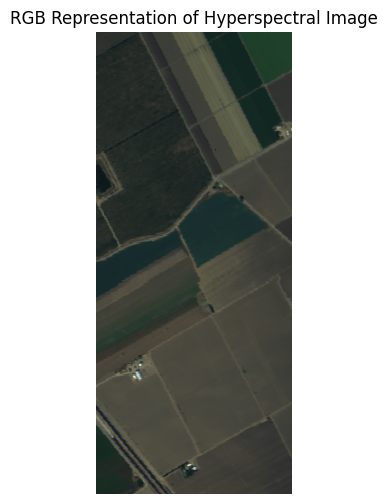

In [3]:
# Select the apporpriate bands for the RGB approximation
rgb_image = image[:, :, [29, 19, 9]]  

# Normalize the image for display
rgb_image = (rgb_image - rgb_image.min()) / (rgb_image.max() - rgb_image.min())

# Display the image
plt.figure(figsize=(8, 6))
plt.imshow(rgb_image)
plt.title("RGB Representation of Hyperspectral Image")
plt.axis("off")
plt.show()

### Other non-RGB spectral bands

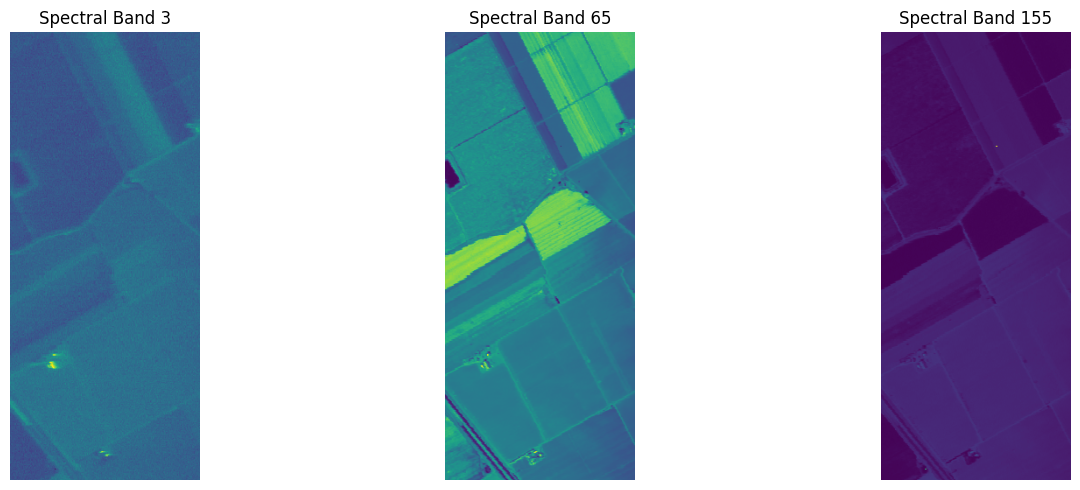

In [4]:
channel3 = image[:, :, 2]    # 3rd spectral band
channel65 = image[:, :, 64]  # 65th spectral band
channel155 = image[:, :, 154] # 155th spectral band

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot each channel with a title
axes[0].imshow(channel3)
axes[0].set_title("Spectral Band 3")

axes[1].imshow(channel65)
axes[1].set_title("Spectral Band 65")

axes[2].imshow(channel155)
axes[2].set_title("Spectral Band 155")

# Remove axis ticks
for ax in axes:
    ax.axis("off")

# Show the plots
plt.tight_layout()
plt.show()

### Labels

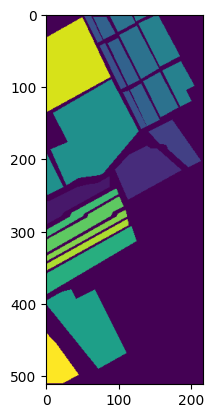

In [5]:
plt.imshow(labels)

### Some statistics

In [6]:
# Get image dimensions and spectral bands
height, width, spectral_bands = image.shape
print(f"Image Dimensions: {height} x {width}")
print(f"Number of Spectral Bands: {spectral_bands}\n")

# Unique crop categories
unique_labels = np.unique(labels)
num_classes = len(unique_labels)
print(f"Total Unique Crop Types: {num_classes}")

# Count the number of pixels per crop type
pixel_counts = np.bincount(labels.ravel())

# Display pixel distribution per crop type
print("\nPixel Count per Crop Type:")
unique, counts = np.unique(labels, return_counts = True)
for i, count in enumerate(pixel_counts):
    print(f"{crop_type[unique[i]]}: {count} pixels")

Image Dimensions: 512 x 217
Number of Spectral Bands: 204

Total Unique Crop Types: 17

Pixel Count per Crop Type:
Undefined: 56975 pixels
Brocoli_green_weeds_1: 2009 pixels
Brocoli_green_weeds_2: 3726 pixels
Fallow: 1976 pixels
Fallow_rough_plow: 1394 pixels
Fallow_smooth: 2678 pixels
Stubble: 3959 pixels
Celery: 3579 pixels
Grapes_untrained: 11271 pixels
Soil_vinyard_develop: 6203 pixels
Corn_senesced_green_weeds: 3278 pixels
Lettuce_romaine_4wk: 1068 pixels
Lettuce_romaine_5wk: 1927 pixels
Lettuce_romaine_6wk: 916 pixels
Lettuce_romaine_7wk: 1070 pixels
Vinyard_untrained: 7268 pixels
Vinyard_vertical_trellis: 1807 pixels


## Preprocessing

### Restructuring

In [31]:
# Reshape the hyperspectral image and labels
reshaped_image = image.reshape(-1, image.shape[-1], order='C')
reshaped_labels = labels.ravel(order='C')

# Remove "Undefined" category (label 0)
valid_indices = reshaped_labels != 0
clean_image = reshaped_image[valid_indices]
clean_labels = reshaped_labels[valid_indices]

### Dimensionality reduction

In [ ]:
scaled = StandardScaler().fit_transform(clean_image)
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
tsne_crops = tsne.fit_transform(scaled)
labels = clean_labels.reshape(-1, 1)  
tsne_crops = np.hstack((labels, tsne_crops))
np.save('data/cropclustering/tsne_crops.npy', tsne_crops)

c:\Users\seppe\OneDrive\Desktop\Cursussen\Big Data Algorithms\Project\BDA-project\.env\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


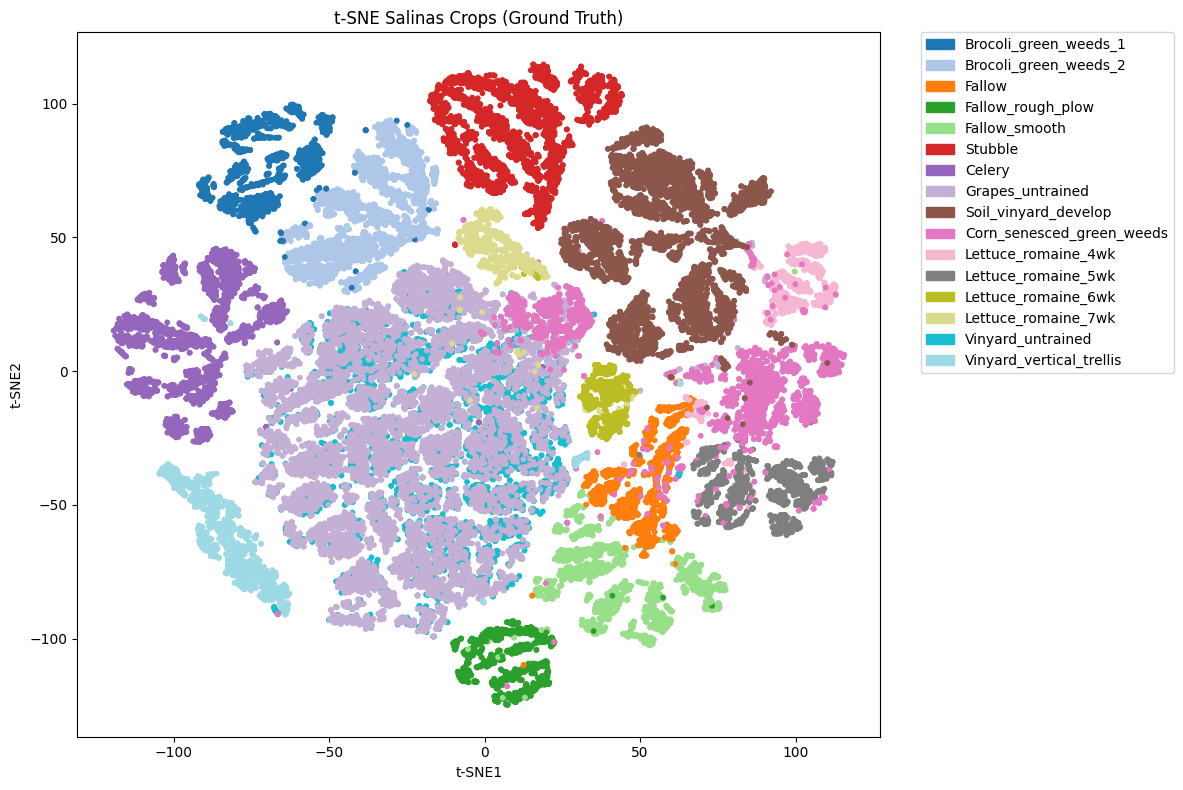

In [14]:
tsne_crops = np.load("data/cropclustering/tsne_crops.npy")
plt.figure(figsize=(12, 8))
scatter = plt.scatter(tsne_crops[:, 1], tsne_crops[:, 2], c=tsne_crops[:, 0], cmap='tab20', s=10)
plt.title('t-SNE Salinas Crops (Ground Truth)')
plt.xlabel('t-SNE1')
plt.ylabel('t-SNE2')

handles = [mpatches.Patch(color=scatter.cmap(scatter.norm(i)), label=crop_type[i]) for i in range(1, len(crop_type))]
plt.legend(handles=handles, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.tight_layout()
plt.show()

## Clustering

In [15]:
tsne_crops = tsne_crops[:, 1:]

n_clusters = 16
iters = 100

results = {}

In [16]:
# Run K-Means
start = time.time()
kmeans_cost, kmeans_centers, kmeans_labels, kmeans_sil = SI.run_kmeans(tsne_crops, n_clusters)
results["KMeans"] = {"cost": kmeans_cost, "silhouette": kmeans_sil}
print("K-Means run time: {:.2f} seconds".format(time.time() - start))

K-Means run time: 38.45 seconds


In [17]:
# Run PSO
start = time.time()
pso_cost, pso_centers, pso_labels, pso_sil, pso_pos_history, pso_cost_history = SI.run_pso(tsne_crops, n_clusters, iters, n_particles=30, options={'c1': 1.5, 'c2': 1.5, 'w': 0.7}, record_history=True)
results["PSO"] = {"cost": pso_cost, "silhouette": pso_sil}
print("PSO run time: {:.2f} seconds".format(time.time() - start))

PSO run time: 61.59 seconds


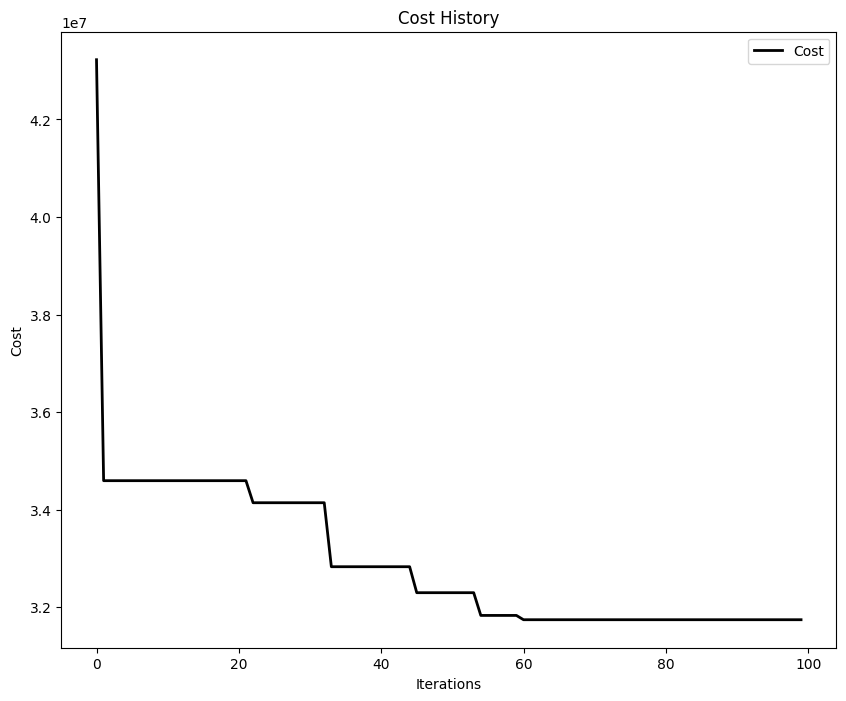

In [18]:
plot_cost_history(cost_history=pso_cost_history)
plt.show()

2025-04-17 17:46:58,873 - matplotlib.animation - WARNING - MovieWriter imagemagick unavailable; using Pillow instead.
2025-04-17 17:46:58,874 - matplotlib.animation - INFO - Animation.save using <class 'matplotlib.animation.PillowWriter'>


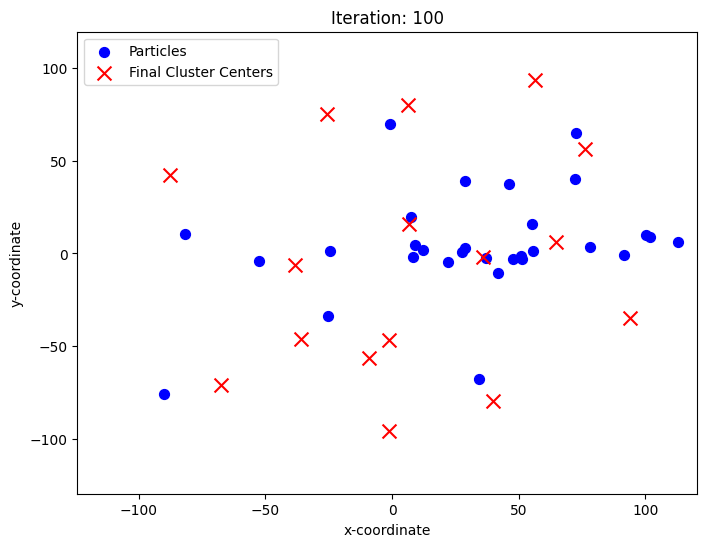

In [19]:
# Create the animation
ani = SI.animate_sa(tsne_crops, pso_pos_history, pso_centers)

# Save the animation as a GIF using imagemagick writer
ani.save('../results/crops/pso_animation.gif', writer='imagemagick', fps=10)

In [20]:
# Run ABC
start = time.time()
abc_cost, abc_centers, abc_labels, abc_sil, abc_history = SI.run_abc(tsne_crops, n_clusters, iters, n_food_sources=30, limit=20, record_history=True)
results["ABC"] = {"cost": abc_cost, "silhouette": abc_sil}
print("ABC run time: {:.2f} seconds".format(time.time() - start))

ABC run time: 61.80 seconds


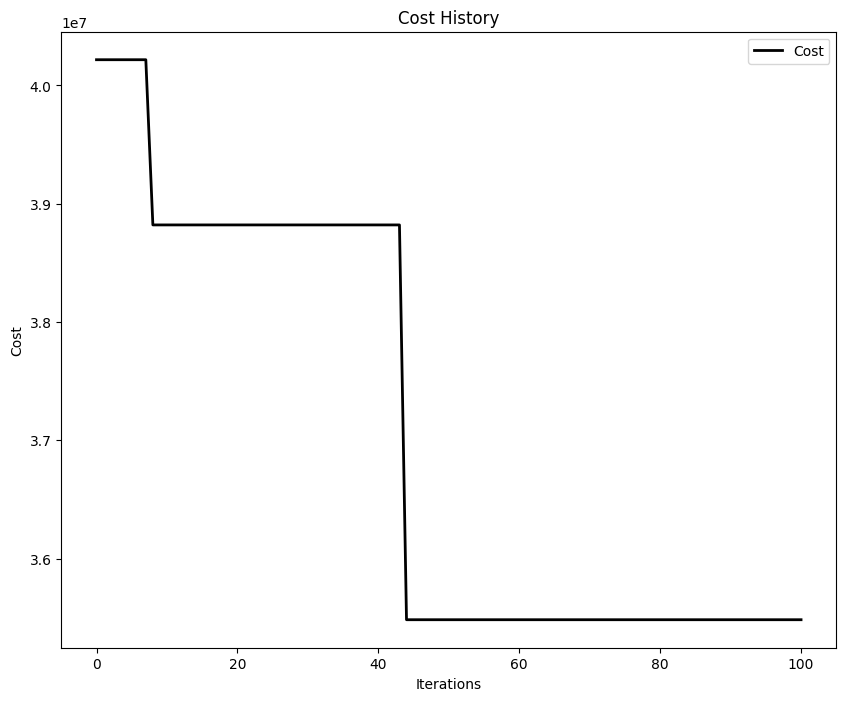

In [21]:
plot_cost_history(cost_history=abc_history["costs"])
plt.show()

2025-04-17 17:48:39,579 - matplotlib.animation - WARNING - MovieWriter imagemagick unavailable; using Pillow instead.
2025-04-17 17:48:39,579 - matplotlib.animation - INFO - Animation.save using <class 'matplotlib.animation.PillowWriter'>


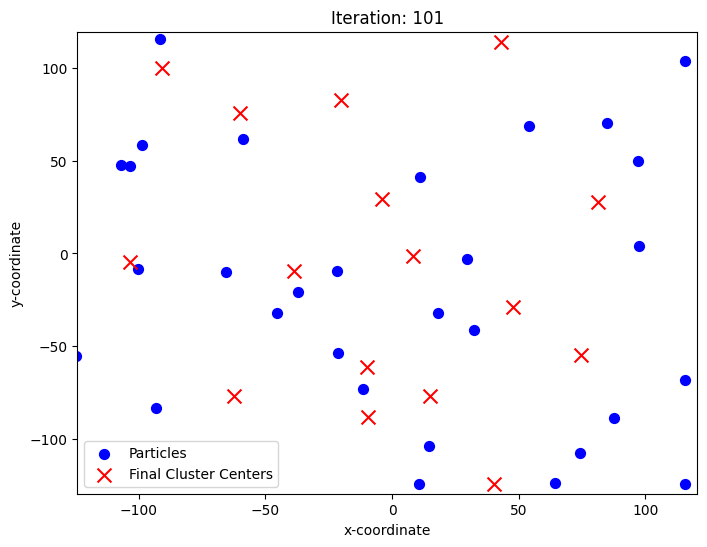

In [22]:
ani = SI.animate_sa(tsne_crops, abc_history["positions"], abc_centers)
ani.save('../results/crops/abc_animation.gif', writer='imagemagick', fps=10)

In [23]:
# Run ACOR (ACO variant)
start = time.time()
acor_cost, acor_centers, acor_labels, acor_sil, acor_history = SI.run_acor(tsne_crops, n_clusters, iters, archive_size=30, ants=30, q=0.5, xi=0., record_history=True)
results["ACOR"] = {"cost": acor_cost, "silhouette": acor_sil}
print("ACOR run time: {:.2f} seconds".format(time.time() - start))

ACOR run time: 62.10 seconds


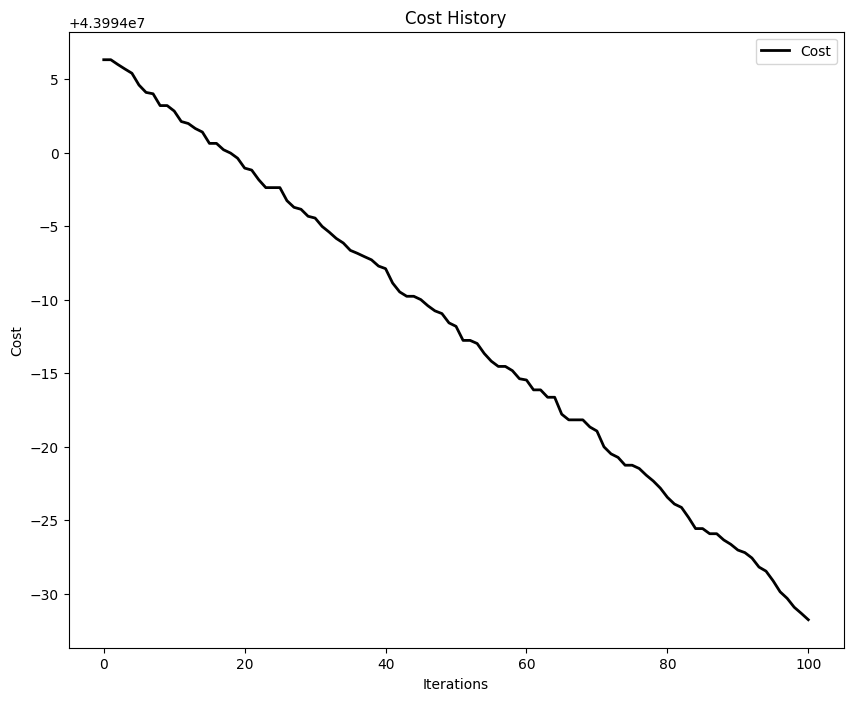

In [24]:
plot_cost_history(cost_history=acor_history["costs"])
plt.show()

2025-04-17 17:50:57,868 - matplotlib.animation - WARNING - MovieWriter imagemagick unavailable; using Pillow instead.
2025-04-17 17:50:57,870 - matplotlib.animation - INFO - Animation.save using <class 'matplotlib.animation.PillowWriter'>


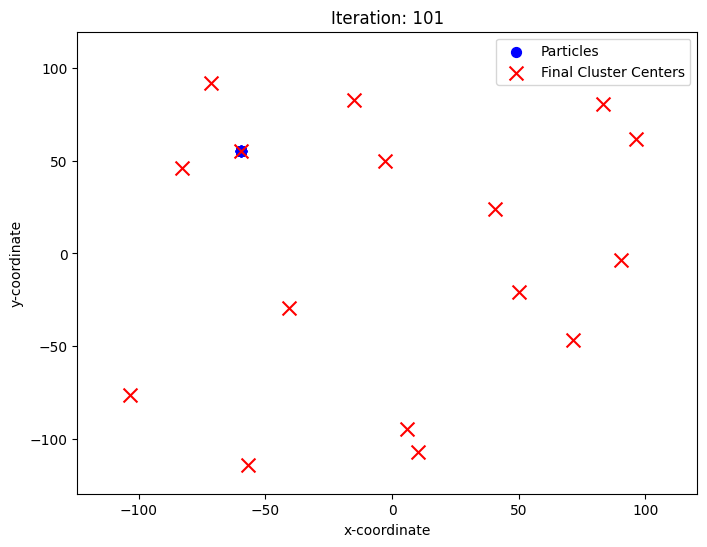

In [25]:
ani = SI.animate_sa(tsne_crops, acor_history["archives"], acor_centers)
ani.save('../results/crops/acor_animation.gif', writer='imagemagick', fps=10)

## Results

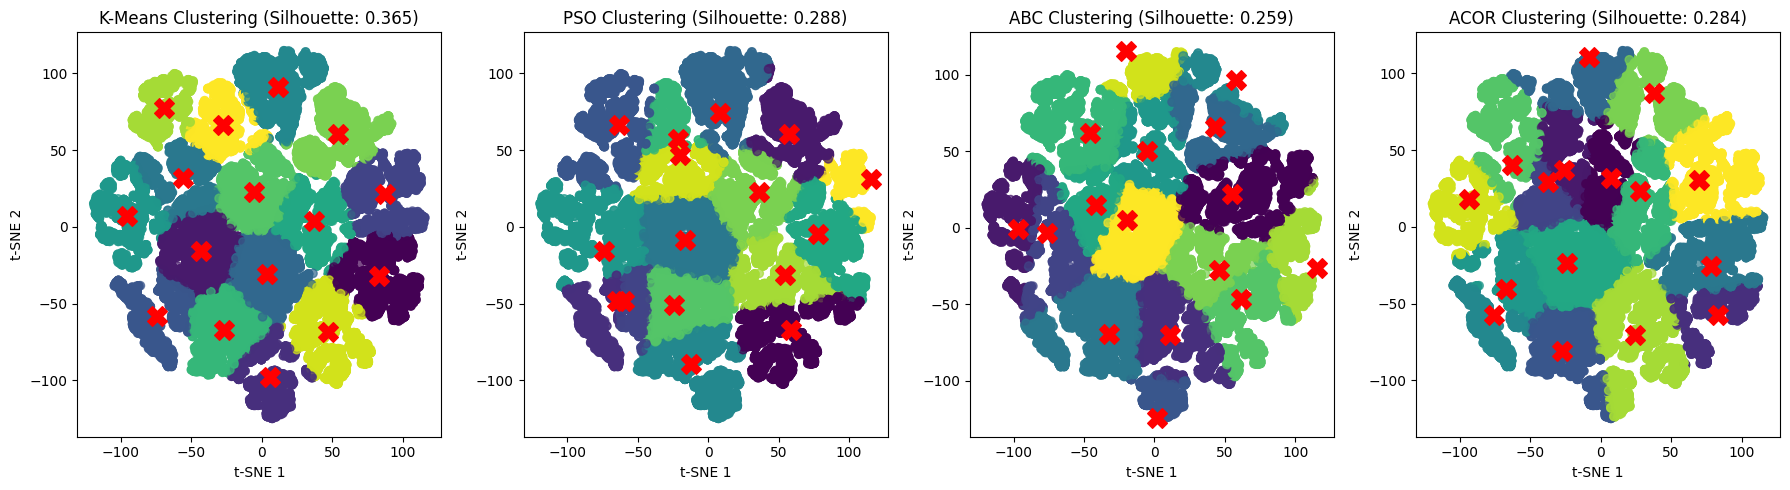

Clustering Comparison Results:
KMeans: Cost = 21938938.13, Silhouette Score = 0.365
PSO: Cost = 32327283.29, Silhouette Score = 0.288
ABC: Cost = 37484713.35, Silhouette Score = 0.259
ACOR: Cost = 33183532.07, Silhouette Score = 0.284


In [6]:
plt.figure(figsize=(18, 5))

plt.subplot(1, 4, 1)
plt.scatter(tsne_crops[:, 0], tsne_crops[:, 1], c=kmeans_labels, cmap='viridis', alpha=0.7)
plt.scatter(kmeans_centers[:, 0], kmeans_centers[:, 1], c='red', s=200, marker='X')
plt.title("K-Means Clustering (Silhouette: {:.3f})".format(kmeans_sil))
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")

plt.subplot(1, 4, 2)
plt.scatter(tsne_crops[:, 0], tsne_crops[:, 1], c=pso_labels, cmap='viridis', alpha=0.7)
plt.scatter(pso_centers[:, 0], pso_centers[:, 1], c='red', s=200, marker='X')
plt.title("PSO Clustering (Silhouette: {:.3f})".format(pso_sil))
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")

plt.subplot(1, 4, 3)
plt.scatter(tsne_crops[:, 0], tsne_crops[:, 1], c=abc_labels, cmap='viridis', alpha=0.7)
plt.scatter(abc_centers[:, 0], abc_centers[:, 1], c='red', s=200, marker='X')
plt.title("ABC Clustering (Silhouette: {:.3f})".format(abc_sil))
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")

plt.subplot(1, 4, 4)
plt.scatter(tsne_crops[:, 0], tsne_crops[:, 1], c=acor_labels, cmap='viridis', alpha=0.7)
plt.scatter(acor_centers[:, 0], acor_centers[:, 1], c='red', s=200, marker='X')
plt.title("ACOR Clustering (Silhouette: {:.3f})".format(acor_sil))
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")

plt.tight_layout()
plt.show()

print("Clustering Comparison Results:")
for algo, res in results.items():
    print(f"{algo}: Cost = {res['cost']:.2f}, Silhouette Score = {res['silhouette']:.3f}")